In [1]:
# WARNING: extremely unoptimized code ahead
# may take up ~5GB of memory when runs

In [2]:
import os
import re
import spacy
import numpy as np
from scipy.sparse import coo_matrix, vstack
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
def process_email(email_path, mapping):
    # Pre-process emails:
    #     - Remove "Subject: " at the beginning, only apply to this dataset, change this if using different dataset
    #     - Remove non-word characters
    #     - Lemmatize the remaining words
    #     - Keep only words that appear in the dictionary (mapping)
    #     - Store the pre-processed words of the email in a list
    #
    
    with open(email_path, "r") as file:
        lines = file.readlines()

    # remove "Subject: " at the beginning
    to_remove = "Subject: "
    if lines and lines[0].startswith(to_remove):
        lines[0] = lines[0][len(to_remove):]

    # remove newlines
    temp = "".join(lines).replace("\n", " ")
    # remove non-words
    temp = re.sub(r'[^a-zA-Z\s]', '', temp)
    # remove redundant spaces
    #content = temp.split()
    doc = nlp(temp.lower())
    content = [token.lemma_ for token in doc if (lemma := token.lemma_) in mapping]
    
    return content

In [5]:
def process_folder(folder_path, mapping):
    # Pre-process emails in folder
    # Returns a list of lists, where each inner list contains the pre-processed words of an email
    
    processed_email_list = []
    count = 0
    
    print("processed:    0 file")
    
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        content = process_email(file_path, mapping)
        
        processed_email_list.append(content)
        
        count += 1
        
        if count % 1000 == 0:
            print(f"processed: {count} files")
            
    print(f"processed: {count} files\nprocessing DONE")
        
    return processed_email_list

In [6]:
def get_data(emails_list, mapping):
    # Returns: X: 2d matrix, X[i] corresponds to bag-of-words vector of i-th email
    
    X = np.zeros((len(emails_list), len(mapping)), dtype=np.int64)
    
    for i in range(len(emails_list)):
        for word in emails_list[i]:
            if word in mapping:
                X[i][mapping[word]] += 1
            #else:
            #    X[i][mapping["-unknown-"]] += 1
    
    return X

# Get dictionary:

In [7]:
dict_path = r"dataset\dictionary.txt"

with open(dict_path, "r") as file:
    temp = [line.strip() for line in file]
    
#temp.append("-unknown-")
# use to map each word to an index of bag-of-word vector
mapping = {word: index for index, word in enumerate(temp)}

# Get train data

In [8]:
emails = process_folder(r"dataset\train\spam", mapping)

X_train_spam = get_data(emails, mapping)
y_train_spam = np.ones(len(emails))
X_train_spam = coo_matrix(X_train_spam)
print("Got X_train_spam")

processed:    0 file
processed: 1000 files
processed: 2000 files
processed: 3000 files
processed: 4000 files
processed: 5000 files
processed: 5650 files
processing DONE
Got X_train_spam


In [9]:
emails = process_folder(r"dataset\train\ham", mapping)

X_train_ham = get_data(emails, mapping)
y_train_ham = np.zeros(len(emails))
X_train_ham = coo_matrix(X_train_ham)
print("Got X_train_ham")

processed:    0 file
processed: 1000 files
processed: 2000 files
processed: 3000 files
processed: 4000 files
processed: 5000 files
processed: 5335 files
processing DONE
Got X_train_ham


In [10]:
X_train = vstack([X_train_spam, X_train_ham])
y_train = np.concatenate((y_train_spam, y_train_ham))

del X_train_spam, X_train_ham, y_train_spam, y_train_ham

# shuffle just for fun, result will be the same as not shuffling
X_train, y_train = shuffle(X_train, y_train)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")

X_train: (10985, 303633), y_train: (10985,)


# Get test data

In [11]:
emails = process_folder(r"dataset\test\spam", mapping)

X_test_spam = get_data(emails, mapping)
y_test_spam = np.ones(len(emails))
X_test_spam = coo_matrix(X_test_spam)
print("Got X_test_spam")

processed:    0 file
processed: 1000 files
processed: 1499 files
processing DONE
Got X_test_spam


In [12]:
emails = process_folder(r"dataset\test\ham", mapping)

X_test_ham = get_data(emails, mapping)
y_test_ham = np.zeros(len(emails))
X_test_ham = coo_matrix(X_test_ham)
print("Got X_test_ham")

processed:    0 file
processed: 1000 files
processed: 1630 files
processing DONE
Got X_test_ham


In [13]:
X_test = vstack([X_test_spam, X_test_ham])
y_test = np.concatenate((y_test_spam, y_test_ham))

del X_test_spam, X_test_ham, y_test_spam, y_test_ham

X_test, y_test = shuffle(X_test, y_test)

# Build model

In [14]:
clf_multinomial = MultinomialNB(alpha=1)

clf_multinomial.fit(X_train, y_train)

y_pred_multinomial = clf_multinomial.predict(X_test)

print(accuracy_score(y_test, y_pred_multinomial))

0.9849792265899648


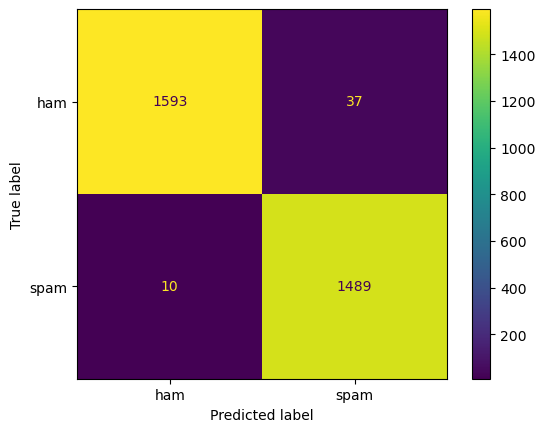

In [15]:
cm = confusion_matrix(y_test, y_pred_multinomial, labels=clf_multinomial.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["ham", "spam"])
disp.plot()
#plt.savefig("confusion_matrix.png")
plt.show()

# Demo

In [35]:
email_path = r"C:\Users\PC MY TU\Desktop\final_project\dataset\test\spam\5328.2005-07-15.BG.spam.txt"
#email_path = r"C:\Users\PC MY TU\Desktop\final_project\dataset\test\spam\1301.2004-11-10.BG.spam.txt"

with open(email_path, "r") as file:
    content = file.readlines()

processed_content = process_email(email_path, mapping)
print(f"Original email:\n{content}\n\nProcessed email:\n{processed_content}\n")

X = np.zeros((1, len(mapping)), dtype=np.int64)

for word in processed_content:
    if word in mapping:
        X[0][mapping[word]] += 1

pred = clf_multinomial.predict(X)

print(f"p(c=0) = {clf_multinomial.class_log_prior_[0]}, p(c=1) = {clf_multinomial.class_log_prior_[1]}")

spam_log_prob = clf_multinomial.class_log_prior_[0]
ham_log_prob = clf_multinomial.class_log_prior_[1]
log_prob = clf_multinomial.feature_log_prob_
for word in processed_content:
    print(f"x_i = {word:<10}\tp(x_i|c=0) = {log_prob[0][mapping[word]]:<10.2f}\tp(x_i|c=1) = {log_prob[1][mapping[word]]:<10.2f}")
    spam_log_prob += log_prob[1][mapping[word]]
    ham_log_prob += log_prob[0][mapping[word]]
    
print(f"\nham log probability: {ham_log_prob}\nspam log probability: {spam_log_prob}")

if pred == 1:
    print("\nspam!")
else:
    print("\nnot spam!")

Original email:
['Subject: re : [ 618 ]\n', 'quality drugs at very reasonable prices . viagra at $ 3 . 19\n', 'it is only one click away\n', '\x00']

Processed email:
['re', 'quality', 'drug', 'at', 'very', 'reasonable', 'price', 'at', 'it', 'be', 'only', 'one', 'click', 'away']

p(c=0) = -0.7222418210828572, p(c=1) = -0.664875160678223
x_i = re        	p(x_i|c=0) = -5.96     	p(x_i|c=1) = -7.32     
x_i = quality   	p(x_i|c=0) = -9.49     	p(x_i|c=1) = -8.10     
x_i = drug      	p(x_i|c=0) = -11.95    	p(x_i|c=1) = -8.22     
x_i = at        	p(x_i|c=0) = -5.44     	p(x_i|c=1) = -5.91     
x_i = very      	p(x_i|c=0) = -7.05     	p(x_i|c=1) = -7.44     
x_i = reasonable	p(x_i|c=0) = -10.01    	p(x_i|c=1) = -10.91    
x_i = price     	p(x_i|c=0) = -6.65     	p(x_i|c=1) = -6.39     
x_i = at        	p(x_i|c=0) = -5.44     	p(x_i|c=1) = -5.91     
x_i = it        	p(x_i|c=0) = -5.54     	p(x_i|c=1) = -5.44     
x_i = be        	p(x_i|c=0) = -3.68     	p(x_i|c=1) = -3.86     
x_i = only 

In [36]:
# find wrongly predicted email

folderpath = r"C:\Users\PC MY TU\Desktop\final_project\dataset\test\spam"
#folderpath = r"C:\Users\PC MY TU\Desktop\final_project\dataset\test\ham"

for filename in os.listdir(folderpath):
    file_path = os.path.join(folderpath, filename)

    content = process_email(file_path, mapping)

    X = np.zeros((1, len(mapping)), dtype=np.int64)

    for word in content:
        if word in mapping:
            X[0][mapping[word]] += 1

    if clf_multinomial.predict(X) != 1:
        print(filename)

0666.2004-09-29.BG.spam.txt
0681.2004-09-29.BG.spam.txt
0961.2004-10-18.BG.spam.txt
1031.2004-10-25.BG.spam.txt
1038.2004-10-25.BG.spam.txt
1301.2004-11-10.BG.spam.txt
1415.2004-11-16.BG.spam.txt
2719.2005-01-26.BG.spam.txt
2853.2005-02-01.BG.spam.txt
5136.2005-07-04.BG.spam.txt
